In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import linear_model

from keras import *
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from tensorflow.keras import regularizers
from keras.optimizers import Adam, RMSprop
from keras.backend import clear_session

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
train = pd.read_csv("/content/drive/MyDrive/AML project/train_manipulated_integrated.csv")

In [3]:
y_train = train['trip_duration'].values.reshape(-1, 1)

X_train = train.drop(columns = ['trip_duration'])

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.30,
                                                  random_state = 1234)

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.15,
                                                  random_state = 1234)

In [5]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(857057, 48)
(151246, 48)
(432130, 48)


In [6]:
#si separano le dummies dalle quantitative

X_train_to_stand = X_train[['passenger_count', 'distance',
                                            'maximum temperature', 'minimum temperature',
                                           'average temperature',
                                           'precipitation', 
                                           'snow fall',
                                           'snow depth', 'direction']]

X_train_not_stand = X_train.drop(columns = ['passenger_count', 'distance',
                                            'maximum temperature', 'minimum temperature',
                                           'average temperature',
                                           'precipitation', 
                                           'snow fall',
                                           'snow depth', 'direction']).values


X_val_to_stand = X_val[['passenger_count', 'distance',
                                            'maximum temperature', 'minimum temperature',
                                           'average temperature',
                                           'precipitation', 
                                           'snow fall',
                                           'snow depth', 'direction']]

X_val_not_stand = X_val.drop(columns = ['passenger_count', 'distance',
                                            'maximum temperature', 'minimum temperature',
                                           'average temperature',
                                           'precipitation', 
                                           'snow fall',
                                           'snow depth', 'direction']).values

X_test_to_stand = X_test[['passenger_count', 'distance',
                                            'maximum temperature', 'minimum temperature',
                                           'average temperature',
                                           'precipitation', 
                                           'snow fall',
                                           'snow depth', 'direction']]

X_test_not_stand = X_test.drop(columns = ['passenger_count', 'distance',
                                            'maximum temperature', 'minimum temperature',
                                           'average temperature',
                                           'precipitation', 
                                           'snow fall',
                                           'snow depth', 'direction']).values

In [7]:
scaler = StandardScaler()

X_train_stand = scaler.fit_transform(X_train_to_stand)
y_train_stand = scaler.fit(y_train).transform(y_train)

X_val_stand = scaler.fit(X_train_to_stand).transform(X_val_to_stand)
y_val_stand = scaler.fit(y_train).transform(y_val)

X_test_stand = scaler.fit(X_train_to_stand).transform(X_test_to_stand)
y_test_stand = scaler.fit(y_train).transform(y_test)

In [8]:
X_train = np.concatenate((X_train_stand, X_train_not_stand), axis = 1)
X_val = np.concatenate((X_val_stand, X_val_not_stand), axis = 1)
X_test = np.concatenate((X_test_stand, X_test_not_stand), axis = 1)

y_train = y_train_stand
y_val = y_val_stand
y_test = y_test_stand

In [13]:
#modello no ottimizzato

initializer = tf.keras.initializers.GlorotUniform(seed=1000)

opt = tf.keras.optimizers.SGD(learning_rate= 0.002, momentum=0.3, 
                              nesterov = False)

model_no_opt = Sequential()
model_no_opt.add(Dense(256, input_shape = (48,),
                activation = "relu", 
                kernel_regularizer= regularizers.l2(0.0005),
                kernel_initializer=initializer))
model_no_opt.add(Dense(128,
                activation = "relu",kernel_regularizer= regularizers.l2(0.0005), 
                kernel_initializer=initializer))
model_no_opt.add(Dense(128,
                activation = "relu", 
                kernel_regularizer= regularizers.l2(0.0005),
                kernel_initializer=initializer))
model_no_opt.add(Dense(32,
                activation = "relu", 
                kernel_regularizer= regularizers.l2(0.0005),
                kernel_initializer=initializer))
model_no_opt.add(Dense(1,
                activation = "linear", 
                kernel_regularizer= regularizers.l2(0.0005),
                kernel_initializer=initializer))
model_no_opt.compile(loss = "mse", optimizer= opt, 
                     metrics = [tf.keras.metrics.RootMeanSquaredError()])

model_no_opt.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               12544     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 66,113
Trainable params: 66,113
Non-trainable params: 0
_________________________________________________________________


In [14]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)

history_no_opt = model_no_opt.fit(X_train, y_train, epochs = 100, 
            batch_size = 128, validation_data=(X_val, y_val),
            shuffle = True,
            callbacks = es,
            verbose=2)

Epoch 1/100
6696/6696 - 15s - loss: 0.5691 - root_mean_squared_error: 0.5970 - val_loss: 0.5131 - val_root_mean_squared_error: 0.5513
Epoch 2/100
6696/6696 - 15s - loss: 0.5144 - root_mean_squared_error: 0.5557 - val_loss: 0.4879 - val_root_mean_squared_error: 0.5346
Epoch 3/100
6696/6696 - 15s - loss: 0.4970 - root_mean_squared_error: 0.5462 - val_loss: 0.4749 - val_root_mean_squared_error: 0.5290
Epoch 4/100
6696/6696 - 15s - loss: 0.4846 - root_mean_squared_error: 0.5412 - val_loss: 0.4628 - val_root_mean_squared_error: 0.5240
Epoch 5/100
6696/6696 - 16s - loss: 0.4741 - root_mean_squared_error: 0.5377 - val_loss: 0.4534 - val_root_mean_squared_error: 0.5211
Epoch 6/100
6696/6696 - 15s - loss: 0.4647 - root_mean_squared_error: 0.5349 - val_loss: 0.4440 - val_root_mean_squared_error: 0.5181
Epoch 7/100
6696/6696 - 14s - loss: 0.4560 - root_mean_squared_error: 0.5325 - val_loss: 0.4362 - val_root_mean_squared_error: 0.5165
Epoch 8/100
6696/6696 - 14s - loss: 0.4477 - root_mean_squared

In [20]:
train_no_opt_mse = history_no_opt.history['loss']
val_no_opt_mse = history_no_opt.history['val_loss']

train_no_opt_rmse = history_no_opt.history['root_mean_squared_error']
val_no_opt_rmse = history_no_opt.history['val_root_mean_squared_error']

In [21]:
perf_no_opt_l2 = pd.DataFrame({'epochs': list(np.arange(0, 100)[0:100]), 
                               'loss':train_no_opt_mse,
                               'val_loss':val_no_opt_mse,
                               'rmse': train_no_opt_rmse,
                               'val_rmse': val_no_opt_rmse})

#backup per non riallenare
perf_no_opt_l2.to_csv("/content/drive/MyDrive/perf_no_opt_l2.csv", index = False)
model_no_opt.save("/content/drive/MyDrive/model_no_opt_l2.h5")

In [9]:
#modello ottimizzato

activations = "relu"
units_1 = 144
units_2 = 112
units_3 = 48
lambda_1 = 0.00010187419587125717

initializer = tf.keras.initializers.GlorotUniform(seed=1234)


opt = tf.keras.optimizers.SGD(learning_rate= 0.002, momentum=0.3, 
                              nesterov = False)

model = Sequential()
model.add(Dense(units_1, input_shape = (48,),
                activation = activations, 
                kernel_regularizer= regularizers.l2(lambda_1),
                kernel_initializer=initializer))
model.add(Dense(units_2,
                activation = activations, 
                kernel_regularizer= regularizers.l2(lambda_1),
                kernel_initializer=initializer))
model.add(Dense(units_3,
                activation = activations, 
                kernel_regularizer= regularizers.l2(lambda_1),
                kernel_initializer=initializer))
model.add(Dense(1,
                activation = "linear", 
                kernel_regularizer= regularizers.l2(lambda_1),
                kernel_initializer=initializer))
model.compile(loss = "mse", optimizer=opt, metrics = [tf.keras.metrics.RootMeanSquaredError()])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 144)               7056      
_________________________________________________________________
dense_1 (Dense)              (None, 112)               16240     
_________________________________________________________________
dense_2 (Dense)              (None, 48)                5424      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 49        
Total params: 28,769
Trainable params: 28,769
Non-trainable params: 0
_________________________________________________________________


In [11]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs = 100, 
            batch_size = 128, validation_data=(X_val, y_val),
            shuffle = True,
            callbacks = es,
            verbose=2)

Epoch 1/100
6696/6696 - 16s - loss: 0.3925 - root_mean_squared_error: 0.6044 - val_loss: 0.3375 - val_root_mean_squared_error: 0.5572
Epoch 2/100
6696/6696 - 14s - loss: 0.3430 - root_mean_squared_error: 0.5621 - val_loss: 0.3197 - val_root_mean_squared_error: 0.5410
Epoch 3/100
6696/6696 - 14s - loss: 0.3306 - root_mean_squared_error: 0.5511 - val_loss: 0.3109 - val_root_mean_squared_error: 0.5329
Epoch 4/100
6696/6696 - 14s - loss: 0.3242 - root_mean_squared_error: 0.5454 - val_loss: 0.3059 - val_root_mean_squared_error: 0.5284
Epoch 5/100
6696/6696 - 14s - loss: 0.3199 - root_mean_squared_error: 0.5415 - val_loss: 0.3023 - val_root_mean_squared_error: 0.5251
Epoch 6/100
6696/6696 - 13s - loss: 0.3166 - root_mean_squared_error: 0.5386 - val_loss: 0.2993 - val_root_mean_squared_error: 0.5224
Epoch 7/100
6696/6696 - 13s - loss: 0.3138 - root_mean_squared_error: 0.5362 - val_loss: 0.2971 - val_root_mean_squared_error: 0.5204
Epoch 8/100
6696/6696 - 13s - loss: 0.3116 - root_mean_squared

In [15]:
y_pred = model.predict(X_val)
y_pred_no_opt = model_no_opt.predict(X_val)

In [16]:
r_quadro = r2_score(y_val, y_pred)
r_quadro_no_opt = r2_score(y_val, y_pred_no_opt)

print("r_quadro opt ", r_quadro)
print("r_quadro no opt ", r_quadro_no_opt)

r_quadro opt  0.7616756046895266
r_quadro no opt  0.7642469711159954


In [29]:
metrics_no_opt_train = model_no_opt.evaluate(X_val, y_val, verbose = 0, batch_size = 128)
metrics_no_opt_val = model_no_opt.evaluate(X_val, y_val, verbose = 0, batch_size = 128)
metrics_no_opt_test = model_no_opt.evaluate(X_test, y_test, verbose = 0, batch_size = 128)

metrics_opt_train = model.evaluate(X_train, y_train, verbose = 0, batch_size = 128)
metrics_opt_val = model.evaluate(X_val, y_val, verbose = 0, batch_size = 128)
metrics_opt_test = model.evaluate(X_test, y_test, verbose = 0, batch_size = 128)
##################################


mse_no_opt_train = metrics_no_opt_train[0] #mse
mse_no_opt_val = metrics_no_opt_val[0] #mse
mse_no_opt_test = metrics_no_opt_test[0] #mse

rmse_no_opt_train = metrics_no_opt_train[1] #rmse
rmse_no_opt_val = metrics_no_opt_val[1] #rmse
rmse_no_opt_test = metrics_no_opt_test[1] #rmse

#################################################

mse_opt_train = metrics_opt_train[0] #mse
mse_opt_val = metrics_opt_val[0] #mse
mse_opt_test = metrics_opt_test[0] #mse

rmse_opt_train = metrics_opt_train[1] #rmse
rmse_opt_val = metrics_opt_val[1] #rmse
rmse_opt_test = metrics_opt_val[1] #rmse

###############################################

print("mse train opt", mse_opt_train)
print("mse val opt", mse_opt_val)
print("mse test opt", mse_opt_test)

print("mse train opt", rmse_opt_train)
print("mse val opt", rmse_opt_val)
print("mse test opt", rmse_opt_test)

############################################
print("___________________________")
print("mse train no opt", mse_no_opt_train)
print("mse val no opt", mse_no_opt_val)
print("mse test no opt", mse_no_opt_test)

print("mse train no opt", rmse_no_opt_train)
print("mse val no opt", rmse_no_opt_val)
print("mse test no opt", rmse_no_opt_test)

mse train opt 0.2597505450248718
mse val opt 0.24968664348125458
mse test opt 0.259189248085022
mse train opt 0.49283498525619507
mse val opt 0.482516884803772
mse test opt 0.482516884803772
___________________________
mse train no opt 0.25413379073143005
mse val no opt 0.25413379073143005
mse test no opt 0.2638126611709595
mse train no opt 0.47990673780441284
mse val no opt 0.47990673780441284
mse test no opt 0.489886999130249


In [18]:
train_opt_loss = history.history['loss']
val_opt_loss = history.history['val_loss']

train_opt_rmse = history.history['root_mean_squared_error']
val_opt_rmse = history.history['val_root_mean_squared_error']

perf_opt_l2 = pd.DataFrame({'epochs': list(np.arange(0, 100)[0:100]), 
                               'loss':train_opt_loss,
                               'val_loss':val_opt_loss,
                            'rmse': train_opt_rmse,
                            'val_rmse':val_opt_rmse})
#backup per npn riallenare
perf_opt_l2.to_csv("/content/drive/MyDrive/perf_opt_l2.csv", index = False)
model.save("/content/drive/MyDrive/model_opt_l2.h5")

Text(0.5, 1.0, 'confronto performance regolarizzazione L2')

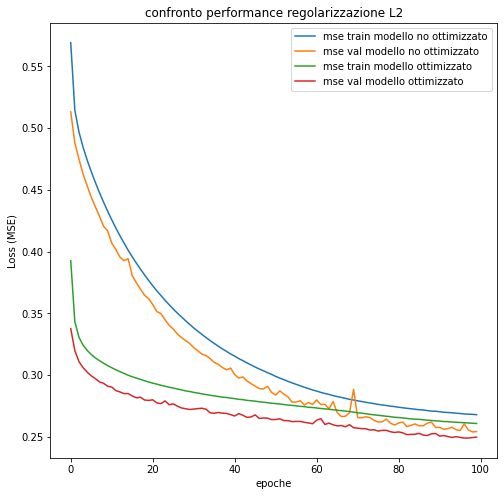

In [22]:
plt.figure(figsize=(8, 8))
plt.plot(train_no_opt_mse, label = "mse train modello no ottimizzato")
plt.plot(val_no_opt_mse, label = "mse val modello no ottimizzato")
plt.plot(train_opt_loss, label = "mse train modello ottimizzato")
plt.plot(val_opt_loss, label = "mse val modello ottimizzato")
plt.legend()
plt.ylabel("Loss (MSE)")
plt.xlabel("epoche")
plt.title("confronto performance regolarizzazione L2")